In [1]:
import os
from tqdm import trange

import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

import matplotlib.pyplot as plt

In [2]:
training_data = datasets.MNIST(
    root='../data',
    train=True,
    download=False,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

test_data = datasets.MNIST(
    root='../data',
    train=False,
    download=False,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

In [3]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [4]:
def display_random_image(data: DataLoader):
    random_number = np.random.randint(1, 5)
    for i in range(random_number):
        train_features, train_labels = next(iter(train_dataloader))

    image_features, image_label = train_features[random_number], train_labels[random_number]

    plt.imshow(image_features.squeeze(), cmap='gray')
    plt.title(torch.argmax(image_label).item())

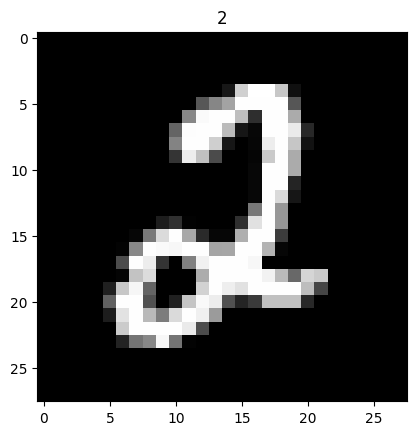

In [5]:
display_random_image(train_dataloader)

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [7]:
class SimpleCNN(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.simple_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(4, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(36, 10)
        )

    def forward(self, x):
        logits = self.simple_stack(x)
        return logits

In [8]:
model = SimpleCNN()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
def train_epoch(dataloader: DataLoader, model: SimpleCNN, loss_fn: nn.CrossEntropyLoss, optimizer: torch.optim):
    model.to(device)
    model.train()
    epoch_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)

    return avg_loss

In [10]:
def test_epoch(model: SimpleCNN, dataloader: DataLoader, loss_fn: nn.CrossEntropyLoss):
    model.eval()

    epoch_accuracy = 0
    epoch_loss = 0
    total_samples = 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            logits = model(X)

            pred = logits.argmax(dim=1)
            labels = y.argmax(dim=1)

            epoch_loss += loss_fn(logits, y).item()
            
            correct_preds = (pred == labels).sum().item()
            epoch_accuracy += correct_preds
            total_samples += labels.size(0)

    epoch_accuracy = (epoch_accuracy / total_samples) * 100
    epoch_loss /= total_samples

    return epoch_accuracy, epoch_loss

In [11]:
def train(model, train_dataloader, test_dataloader, loss_fn, optimizer, epoches):
    train_losses = np.empty(epoches)
    test_losses = np.empty(epoches)
    test_accs = np.empty(epoches)

    for epoch in (pbar := trange(epoches)):
        train_loss = train_epoch(train_dataloader, model, loss_fn, optimizer)
        accuracy, test_loss = test_epoch(model, test_dataloader, loss_fn)

        train_losses[epoch] = train_loss
        test_losses[epoch] = test_loss
        test_accs[epoch] = accuracy

    print(f"Finished with accuracy of {accuracy}% and loss equal to {test_loss}")

    return train_losses, test_losses, test_accs

In [12]:
train_losses, test_losses, test_accuracies = train(model, train_dataloader, test_dataloader, loss_fn, optimizer, 10)

  0%|          | 0/10 [00:15<?, ?it/s]


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [230]:
def predict(test_dataloader, model):
    random_number = np.random.randint(1, 6)

    image_features, image_labels = None, None
    for i in range(random_number):
        image_features, image_labels = next(iter(test_dataloader))

    pred = model(image_features)
    print(f"Predicted -> {torch.argmax(pred[random_number])} and the real is {torch.argmax(image_labels[random_number])}")

In [232]:
predict(test_dataloader, model)

Predicted -> 6 and the real is 6


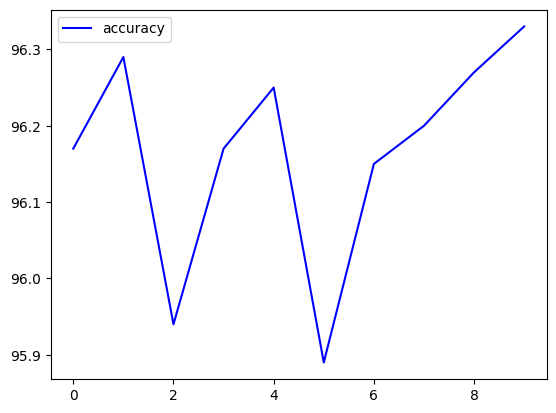

In [233]:
plt.plot(test_accuracies, c='blue', label='accuracy')
plt.legend()
plt.show()

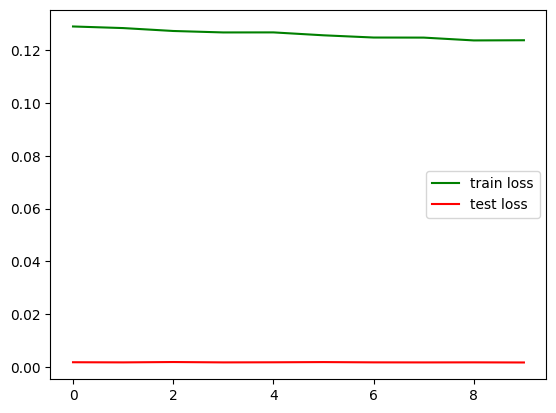

In [234]:
plt.plot(train_losses, c='green', label='train loss')
plt.plot(test_losses, c='red', label='test loss')
plt.legend()
plt.show()